## Projet 5 : Segmentez des clients d'un site e-commerce

## Contexte

Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.

Première urgence : l'implémentation de requêtes SQL urgentes.

Deuxième urgence :  fournir aux équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

## Librairies utilisées avec le langage Python:

In [106]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import seaborn as sns
import sqlite3
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.stats import kstest
import plotly.graph_objects as go
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables

def show_miss_val(data : pd.DataFrame) -> pd.DataFrame:

    '''Prend dataframe `data` en entrée et calcule le pourcentage de valeurs manquantes pour chaque colonne
    Args:
        data (pd.DataFrame): Dataframe sur lequel les pourcentages de valeurs manquantes seront calculées
    Sortie:
        pd.DataFrame: Dataframe avec le pourcentage de valeurs manquantes pour chaque colonne

    '''
    variables = []
    miss_val = []

    for item in data.columns:
        variables.append(item)
        #Calcul du pourcentage de valeurs manquantes
        miss_val.append(data[item].isna().mean())

    # Création d'un dataframe avec le résultat
    output = pd.DataFrame({
        'variable': variables,
        'miss_val': miss_val
    })
    # Affichage d'un message récapitulant le nombre de variables et le nombre d'entre elles qui a des valeurs manquantes
    num_total_vars = data.shape[1]
    num_vars_missing = output[output['miss_val'] != 0].shape[0]
    print (f"Notre dataframe a  {num_total_vars} variables.\n"
           f"Il y a  {num_vars_missing} variables contenant des valeurs manquantes.")

    # Retourne les colonnes qui ont des valeurs manquantes avec le pourcentage de valeurs manquantes de chacune d'entre elles
    return output[output['miss_val'] != 0].sort_values('miss_val')

In [3]:
def pd_to_sqlDB(input_df: pd.DataFrame,
                table_name: str,
                db_name: str = 'default.db') -> None:

    '''Prend dataframe `input_df` en entrée et le tranforme en une table SQLITE `table_name`
    Args:
        input_df (pd.DataFrame): Dataframe contenant les données à télécharger dans SQLITE
        table_name (str): Nom de la table SQLITE à créer
        db_name (str, optional): Nom de la base de données SQLITE dans laquelle la table est créée.
                                 Par défaut : 'default.db'.
    '''

    # Step 1: Configuration

    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s: %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')

    # Step 2: Trouver les colonnes du dataframe
    cols = input_df.columns
    cols_string = ','.join(cols)
    val_wildcard_string = ','.join(['?'] * len(cols))

    # Step 3: Connexion à la DB ou création si elle n'existe pas
    con = sqlite3.connect(db_name)
    cur = con.cursor()
    logging.info(f'SQL DB {db_name} created')

    # Step 4: Creation de la Table
    sql_string = f"""CREATE TABLE {table_name} ({cols_string});"""
    cur.execute(sql_string)
    logging.info(f'SQL Table {table_name} created with {len(cols)} columns')

    # Step 5: Téléchargement des données
    rows_to_upload = input_df.to_dict(orient='split')['data']
    sql_string = f"""INSERT INTO {table_name} ({cols_string}) VALUES ({val_wildcard_string});"""
    cur.executemany(sql_string, rows_to_upload)
    logging.info(f'{len(rows_to_upload)} rows uploaded to {table_name}')

    # Step 6: Commit et fermeture de la connexion
    con.commit()
    con.close()

In [4]:
def sql_query_to_pd(sql_query_string: str,
                    db_name: str ='default.db') -> pd.DataFrame:
    '''Execute une requête SQL et retourne le résultat sous forme d'un dataframe
    Args:
        sql_query_string (str): Requête SQL à exécuter
        db_name (str, optional): Nom de la DB SQLITEoù la requête est exécutée.
                                 Par défaut : 'default.db'.
    Sortie:
        pd.DataFrame: Resultats de la requête SQL sous forme d'un dataframe
    '''
    # Step 1: Connexion à la DB
    con = sqlite3.connect(db_name)

    # Step 2: Execution de la requête SQL
    cursor = con.execute(sql_query_string)

    # Step 3: Recherche des données et nom de colonnes
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # Step 4: Fermeture de la connexion
    con.close()

    # Step 5:Sortie sous forme d'un dataframe
    return pd.DataFrame(result_data, columns=cols)

## Simulation pour élaborer un contrat de maintenance :


Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

Pour cela, nous devons recalculer toutes les features semaine par semaine.

### Création du dataframe complet :

In [5]:
data_fe_client = pd.read_csv('D:/tutorial-env/OCR/Projet5/data_fe_client.csv')
data_rfm_client = pd.read_csv('D:/tutorial-env/OCR/Projet5/data_rfm_client.csv')

In [33]:
data=data_fe_client.merge(data_rfm_client,
                          on = 'customer_unique_id',
                          how = 'left')
cols_to_drop = ["customer_unique_id","order_id","payment_total"]
data = data.drop(cols_to_drop, axis = 1)
data = data.rename(columns = {
    "price": "prix",
    "montant": "montant_total",
    "freight_value": "frais_livraison",
    "review_score_moy": "satisfaction",
    "estimated_delivery_delay":"date_livraison_estimee",
    "true_delivery_delay":"date_livraison_reelle",
    "late_delivery": "retard_livraison",
    "payment_payment_installments": "nb_versement"
    }
)
data = data.sort_values('recence', ascending = False)
data = data.reset_index()
data

,index,estimated_delivery_delay,true_delivery_delay,retard_livraison,price,frais_livraison,nb_versement,satisfaction,recence,montant_total
0,69097,46.0,NaN,NaN,32.90,31.67,1.0,1.0,773.0,136.23
1,27245,53.0,NaN,NaN,59.50,15.56,3.0,1.0,772.0,75.06
2,238,17.0,NaN,NaN,0.00,0.00,2.0,1.0,764.0,40.95
3,49312,19.0,55.0,36.0,44.99,2.83,NaN,1.0,762.0,NaN
4,5521,23.0,NaN,NaN,100.00,9.34,1.0,1.0,745.0,109.34
...,...,...,...,...,...,...,...,...,...,...
96091,58524,16.0,NaN,NaN,0.00,0.00,1.0,1.0,18.0,137.03
96092,37382,21.5,6.0,-15.0,65.00,15.38,1.5,2.0,16.0,160.76
96093,65954,12.0,7.0,-5.0,178.00,19.55,1.0,1.0,14.0,592.65
96094,14363,31.0,15.0,-20.0,197.50,24.53,1.0,5.0,1.0,444.06


In [29]:
#  Imputation et normalisation du dataframe
# Créer une instance de SimpleImputer pour imputer les valeurs manquantes
imputer = SimpleImputer(strategy = 'median')

# Imputation
data['nb_versement'] = imputer.fit_transform(data['nb_versement'].values.reshape(-1, 1))
data['montant_total'] = imputer.fit_transform(data['montant_total'].values.reshape(-1, 1))
data['satisfaction'] = imputer.fit_transform(data['satisfaction'].values.reshape(-1, 1))
data['date_livraison_reelle'] = imputer.fit_transform(data['date_livraison_reelle'].values.reshape(-1, 1))
data['retard_livraison'] = imputer.fit_transform(data['retard_livraison'].values.reshape(-1, 1))

data_vm = show_miss_val(data)
data_vm.head(26)

Notre dataframe a 10 variables.
 Il y a 0 variables contenant des valeurs manquantes.


,variable,miss_val


### Transformation de variables pour le clustering :

In [30]:
# Transformation en racine carré de certaines variables pour le clustering
data_scale = data.copy()

data_scale['montant_total'] = np.sqrt(data['montant_total'])
data_scale['frais_livraison'] = np.sqrt(data['frais_livraison'])
data_scale['satisfaction'] = data['satisfaction']
data_scale['retard_livraison'] = data['retard_livraison']
data_scale['nb_versement'] = np.sqrt(data['nb_versement'])


### Découpage du dataframe par période :

In [49]:
 # Fonction permettant de decouper un dataframe par pas de période selon la variable recence en ne gardant que les individus du premier découpage
def split_df_period(df, period_init, period_step, split_nb) :
      '''Decoupe un dataframe par périodes en fonction de la variable 'recence'
    Args:
        df (pd.DataFrame): Dataframe à découper
        period_init (int): Periode initiale
        period_step (int): Pas de période en jours
        split_nb (int): Nombre de découpages
    Sortie:
        dict: Dictionnaire des dataframes découpés
    '''
    dataframes = {}
    df_temp = pd.DataFrame()

    # Découpage initial
    df_temp = df.loc[df['recence'] > period_init]
    dataframes["df_0"] = df_temp
    print ("Dataframe 0 créé. " )

    # Autres découpages par pas de période
    for i in range (1, split_nb):
      df_temp = pd.DataFrame()
      df_temp = df.loc[df['recence'] > period_init - (i * period_step)]

      df_name = "df_" + str(i)
      dataframes[df_name] = df_temp
      print (f"Dataframe {df_name} créé. " )

    return dataframes
    # Retourne un dictionnaire de dataframes découpés par période

In [61]:
df = split_df_period(data_scale,289,7,42)
df

Dataframe 0 créé. 
Dataframe df_1 créé. 
Dataframe df_2 créé. 
Dataframe df_3 créé. 
Dataframe df_4 créé. 
Dataframe df_5 créé. 
Dataframe df_6 créé. 
Dataframe df_7 créé. 
Dataframe df_8 créé. 
Dataframe df_9 créé. 
Dataframe df_10 créé. 
Dataframe df_11 créé. 
Dataframe df_12 créé. 
Dataframe df_13 créé. 
Dataframe df_14 créé. 
Dataframe df_15 créé. 
Dataframe df_16 créé. 
Dataframe df_17 créé. 
Dataframe df_18 créé. 
Dataframe df_19 créé. 
Dataframe df_20 créé. 
Dataframe df_21 créé. 
Dataframe df_22 créé. 
Dataframe df_23 créé. 
Dataframe df_24 créé. 
Dataframe df_25 créé. 
Dataframe df_26 créé. 
Dataframe df_27 créé. 
Dataframe df_28 créé. 
Dataframe df_29 créé. 
Dataframe df_30 créé. 
Dataframe df_31 créé. 
Dataframe df_32 créé. 
Dataframe df_33 créé. 
Dataframe df_34 créé. 
Dataframe df_35 créé. 
Dataframe df_36 créé. 
Dataframe df_37 créé. 
Dataframe df_38 créé. 
Dataframe df_39 créé. 
Dataframe df_40 créé. 
Dataframe df_41 créé. 


{'df_0':        index  date_livraison_estimee  date_livraison_reelle  retard_livraison  \
 0      69097                    46.0                   10.0             -12.0   
 1      27245                    53.0                   10.0             -12.0   
 2        238                    17.0                   10.0             -12.0   
 3      49312                    19.0                   55.0              36.0   
 4       5521                    23.0                   10.0             -12.0   
 ...      ...                     ...                    ...               ...   
 43342   4762                    24.0                   10.0             -14.0   
 43343  63967                    24.0                   19.0              -5.0   
 43344  11010                    30.0                   24.0              -6.0   
 43345  43799                    36.0                   16.0             -20.0   
 43346    232                    31.0                   11.0             -20.0   
 
      

### Clustering des dataframes :

In [154]:
 # Fonction permettant de normaliser et effectuer le clustering sur un dictionnaire de dataframes
def cluster_dict_df(dict_df, cluster_cols):
    '''Normalise et effectue un clustering sur chaque dataframe d'un dictionnaire
    Args:
        dict_df (dict): Dictionnaire de dataframes à clusteriser
        cluster_cols (list): Colonnes utilisées pour le clustering
    Sortie:
        liste_labels(list): Liste des labels des clustering
        dict_df_clust (dict): Dictionnaire des dataframes clusterisés
    '''
    taille_dictionnaire = len(dict_df)
    liste_valeurs = list(dict_df.values())
    liste_labels = list()
    dict_df_clust = {}
    scaler = MinMaxScaler()

    # Entrainement du KMeans sur le dataframe initial
    df_cluster0 = liste_valeurs[0][cluster_cols]
    df_norm0 = pd.DataFrame(scaler.fit_transform(df_cluster0), columns = df_cluster0.columns)
    kmeans = KMeans(
        init ='k-means++',
        n_clusters = 4,
        n_init = 10,
        max_iter = 300,
        random_state = 42
    )
    kmeans.fit(df_norm0)
    liste_labels.append( kmeans.labels_)
    df_cluster0['cluster'] = kmeans.labels_
    dict_df_clust["df_0"] = df_cluster0

    # Prédiction des KMeans sur les autres dataframes
    for i in range (1,taille_dictionnaire):
      df_cluster = liste_valeurs[i][cluster_cols]
      df_norm = pd.DataFrame(scaler.fit_transform(df_cluster), columns = df_cluster.columns)
      labels = kmeans.predict(df_norm)
      liste_labels.append(l)
      df_cluster['cluster'] = labels
      dict_df_clust["df_" + str(i)] = df_cluster

    return liste_labels, dict_df_clust
    # Retourne la liste des labels des clustering  du dictionnaire de dataframes ainsi qu'un dictionne du dataframe avec les labels du clustering

In [155]:
label_list, dict_df_clust = cluster_dict_df(df, ['montant_total','frais_livraison',
                                      'satisfaction','retard_livraison',
                                      'nb_versement'])
label_list

[array([1, 1, 1, ..., 3, 3, 0]),
 array([1, 1, 1, ..., 0, 0, 3]),
 array([1, 1, 1, ..., 3, 1, 1]),
 array([1, 1, 1, ..., 3, 3, 0]),
 array([1, 1, 1, ..., 2, 1, 0]),
 array([1, 1, 1, ..., 3, 3, 3]),
 array([1, 1, 1, ..., 0, 0, 1]),
 array([1, 1, 1, ..., 3, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 0]),
 array([1, 1, 1, ..., 3, 3, 3]),
 array([1, 1, 1, ..., 3, 1, 3]),
 array([1, 1, 1, ..., 0, 0, 3]),
 array([1, 1, 1, ..., 3, 0, 3]),
 array([1, 1, 1, ..., 1, 2, 3]),
 array([1, 1, 1, ..., 2, 0, 2]),
 array([1, 1, 1, ..., 1, 3, 0]),
 array([1, 1, 1, ..., 2, 1, 3]),
 array([1, 1, 1, ..., 3, 0, 0]),
 array([1, 1, 1, ..., 1, 2, 1]),
 array([1, 1, 1, ..., 3, 2, 3]),
 array([1, 1, 1, ..., 3, 2, 1]),
 array([1, 1, 1, ..., 0, 1, 3]),
 array([1, 1, 1, ..., 3, 3, 3]),
 array([1, 1, 1, ..., 3, 2, 0]),
 array([1, 1, 1, ..., 3, 3, 2]),
 array([1, 1, 1, ..., 3, 2, 2]),
 array([1, 1, 1, ..., 2, 0, 2]),
 array([1, 1, 1, ..., 1, 3, 2]),
 array([1, 1, 1, ..., 3, 3, 3]),
 array([1, 1, 1, ..., 2, 2, 0]),
 array([1,

### Stabilité temporelle :

In [53]:
 # Fonction permettant de calculer des ARI par paires dans une liste de labels
def temp_stability_ari(labels_list):
  '''Calcule l'ARI entre les labels du premier découpage et les autres
    Args:
        labels_list (list): Liste des labels des clustering
    Sortie:
        ari_score (list): Liste des scores ARI
  '''
  t = len(labels_list)

  # Nb d'individus du découpage initial
  nombre_lignes_cluster0 = labels_list[0].shape[0]

  # Calcul de l'ARI entre les paires de labels
  ari_score = []

  for i in range(1, t):
      labels_list[i] = labels_list[i][:nombre_lignes_cluster0]
      ari = adjusted_rand_score(labels_list[0], labels_list[i])
      ari_score.append(ari)
      print(f"Le score de l'ARI entre les labels à la position 0 et {i} est de : {ari}")

  return (ari_score)
  # Retourne la liste des labels des ARI calculés pour chaque paire de labels de la liste

In [157]:
ari_list = temp_stability_ari(label_list)


Le score de l'ARI entre les labels à la position 0 et  1 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  2 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  3 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  4 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  5 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  6 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  7 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  8 est de : 0.9999484323411587
Le score de l'ARI entre les labels à la position 0 et  9 est de : 0.9999484323411587
Le score de l'ARI entre les labels à la position 0 et  10 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  11 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  12 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  13 est de : 1.0
Le score de l'ARI entre les labels à la position 0 et  1

In [55]:
j = []
for i in range(1,42):
  j.append(i)


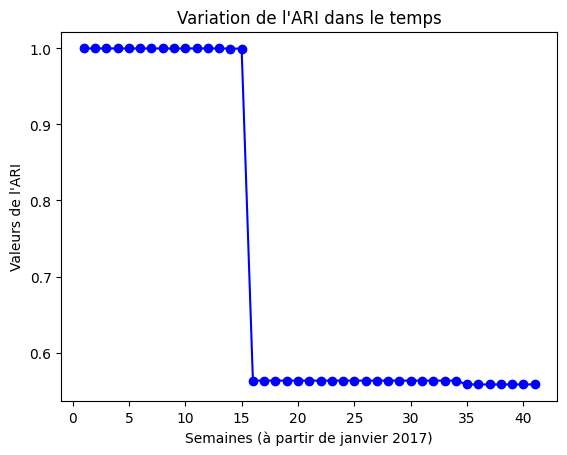

In [56]:
# Créer une figure et un axe
fig, ax = plt.subplots()

# Tracer le graphique
plt.plot(j,
         ari_list,
         marker = 'o',
         linestyle = '-',
         color = 'b')

# Ajouter des titres et des étiquettes d'axe
plt.title("Variation de l'ARI dans le temps")
plt.xlabel('Semaines (à partir de janvier 2017)')
plt.ylabel("Valeurs de l'ARI")

# Afficher le graphique
plt.show()

A partir de la seizième semaine, c'est à dire 16x7j, le score ARI chute
d'environ 0,99 à 0,56.

Pour garder notre algorithme au maximum de son efficacité, nous pourrions proposer un contrat de maintenance tous les trois mois, soit 90 jours.

In [57]:
df_comparaison = pd.DataFrame({
    'Avant': label_list[0],
    'Apres': label_list[16]
})

# Compter le flux entre les clusters avant et après
flux = df_comparaison.groupby(['Avant', 'Apres']).size().reset_index(name='counts')

# Définir les labels des noeuds pour Sankey (clusters avant et après)
labels = ['Avant ' + str(i) for i in np.unique(label_list[0])] + ['Après ' + str(i) for i in np.unique(label_list[16])]

# Créer un dictionnaire pour les indices des labels
label_to_index = {label: i for i, label in enumerate(labels)}

# Sources et cibles (indices des clusters avant et après)
sources = flux['Avant'].apply(lambda x: label_to_index['Avant ' + str(x)]).values
targets = flux['Apres'].apply(lambda x: label_to_index['Après ' + str(x)]).values

# Quantités (flux entre les clusters)
values = flux['counts'].values

# 3. Créer le diagramme de Sankey
fig = go.Figure(go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source=sources,  # Indices des clusters avant
        target=targets,  # Indices des clusters après
        value=values      # Flux entre les clusters
    )
))

# Titre avec le score ARI
fig.update_layout(
    title_text = f"Diagramme de Sankey : Comparaison des Clusters 0 et 16 (ARI = {ari_list[16]})",
    font_size = 10
)

# Afficher le diagramme
py.plot(fig, filename = 'sankey.html')

'sankey.html'

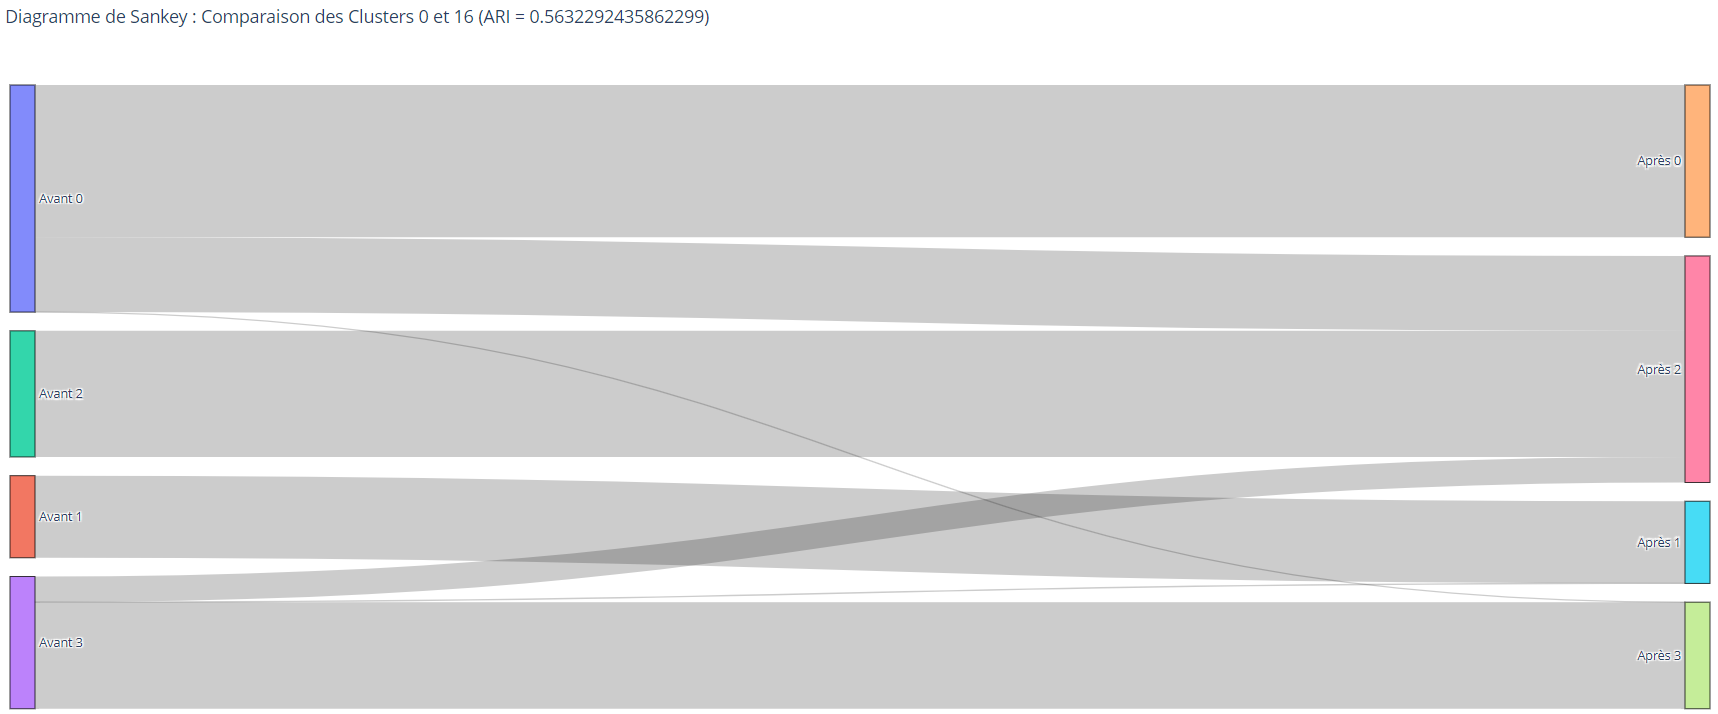

La chute de l'ARI provient principalement d'individus dans les clusters 0 et 3 qui passent dans le cluster 2.

Etudions plus en détail les clusters :

In [159]:
df_0_temp =  dict_df_clust['df_0']
features = df_0_temp.columns[:-1]
df_0_temp_means = df_0_temp.groupby('cluster')[features].mean()
df_0_temp_means

,montant_total,frais_livraison,satisfaction,retard_livraison,nb_versement
cluster,,,,,
0,10.573519,4.214808,3.659092,-12.207797,1.335552
1,12.336207,4.140708,1.232111,-7.323099,1.649467
2,14.405633,4.665270,4.748443,-13.872681,2.590590
3,10.292826,4.115047,4.997876,-13.595998,1.183066


In [160]:
df_16_temp = dict_df_clust['df_16']
features = df_16_temp.columns[:-1]
df_16_temp_means = df_16_temp.groupby('cluster')[features].mean()
df_16_temp_means

,montant_total,frais_livraison,satisfaction,retard_livraison,nb_versement
cluster,,,,,
0,10.266389,4.164454,3.605147,-11.358476,1.190578
1,12.388369,4.276654,1.221751,-5.095643,1.622526
2,13.117288,4.547989,4.734139,-13.286378,2.146791
3,9.821922,4.030468,4.998724,-12.941295,0.999946


Dans ce clustering :
- Cluster 0 : clients satisfaits avec peu d'échelonnement de paiement
- Cluster 1 : clients mécontents
- Cluster 2 : clients très satisfaits avec le panier moyen le plus élevé et beaucoup d'échelonnement de paiement
- Cluster 3 : clients très satisfaits avec le panier moyen le plus faible et peu d'échelonnement de paiement

Donc, à la seixième semaine, des clients très satisfaits avec panier moyen faible et des clients juste satisfaits basculent dans la catégorie des clients très satisfaits avec le panier moyen le plus élevé et beaucoup d'échelonnement de paiement.

Cela peut être expliqué par la moyenne du montant total du cluster 2 qui baisse cette semaine là.

Nous pouvons utiliser le test de Kolmogorov-Smirnov pour voir comment les distributions des variables évoluent dans le temps en fonction de leur distribution initiale :

In [163]:
ks_result = pd.DataFrame(columns = [
    'comparaison ',
    'retard_livraison_stat','retard_livraison_pvalue',
    'frais_livraison_stat','frais_livraison_pvalue',
    'montant_total_stat','montant_total_pvalue',
    'nb_versement_stat','nb_versement_pvalue',
    'satisfaction_stat','satisfaction_pvalue'
])

#  Boucle sur chaque découpage pour comparer avec le découpage initial
for i in range(1,42):
      ks_score = []
      ks_score.append('entre 0 et ' + str(i))

      #  Test KS pour chaque variable
      for var in ['retard_livraison','frais_livraison','montant_total','nb_versement','satisfaction']:
          stat, p = kstest(dict_df['df_0'][var], dict_df['df_'+str(i)][var])
          ks_score.append(stat)
          ks_score.append(p)

      # Enregistrement des résultats
      ks_result.loc[i]=ks_score

In [164]:
ks_result

,comparaison,retard_livraison_stat,retard_livraison_pvalue,frais_livraison_stat,frais_livraison_pvalue,montant_total_stat,montant_total_pvalue,nb_versement_stat,nb_versement_pvalue,satisfaction_stat,satisfaction_pvalue
1,entre 0 et 1,0.004972,6.463494e-01,0.001046,1.000000e+00,0.001253,1.000000,0.002100,9.999736e-01,0.000390,1.000000e+00
2,entre 0 et 2,0.008044,1.093413e-01,0.001182,1.000000e+00,0.001727,1.000000,0.004385,7.801417e-01,0.000426,1.000000e+00
3,entre 0 et 3,0.008982,5.019637e-02,0.002237,9.998396e-01,0.001646,1.000000,0.006846,2.344116e-01,0.000984,1.000000e+00
4,entre 0 et 4,0.010046,1.860018e-02,0.003453,9.445460e-01,0.001940,0.999993,0.007663,1.313649e-01,0.001768,9.999996e-01
5,entre 0 et 5,0.010456,1.172381e-02,0.004021,8.408817e-01,0.002469,0.998754,0.009261,3.547382e-02,0.002000,9.999825e-01
6,entre 0 et 6,0.009428,2.896591e-02,0.004950,6.028577e-01,0.002791,0.992302,0.010491,1.056457e-02,0.003162,9.707229e-01
7,entre 0 et 7,0.003944,8.461888e-01,0.006306,2.920275e-01,0.003728,0.889891,0.011916,2.113031e-03,0.004916,6.032873e-01
8,entre 0 et 8,0.009833,1.765004e-02,0.007301,1.472118e-01,0.004630,0.669963,0.014415,7.728045e-05,0.007583,1.198627e-01
9,entre 0 et 9,0.019326,1.820101e-08,0.007556,1.175939e-01,0.004781,0.621303,0.015844,7.872421e-06,0.012163,1.302674e-03
10,entre 0 et 10,0.027749,3.404068e-17,0.004545,6.769861e-01,0.004506,0.687181,0.015316,1.553139e-05,0.015728,8.171544e-06


In [165]:
ks_result['moyenne_stat'] = ks_result.iloc[:, [1,3,5,7,9]].mean(axis = 1)
ks_result['moyenne_pvalue'] = ks_result.iloc[:, [2,4,6,8,10]].mean(axis  = 1)
ks_result

,comparaison,retard_livraison_stat,retard_livraison_pvalue,frais_livraison_stat,frais_livraison_pvalue,montant_total_stat,montant_total_pvalue,nb_versement_stat,nb_versement_pvalue,satisfaction_stat,satisfaction_pvalue,moyenne_stat,moyenne_pvalue
1,entre 0 et 1,0.004972,6.463494e-01,0.001046,1.000000e+00,0.001253,1.000000,0.002100,9.999736e-01,0.000390,1.000000e+00,0.001952,0.929265
2,entre 0 et 2,0.008044,1.093413e-01,0.001182,1.000000e+00,0.001727,1.000000,0.004385,7.801417e-01,0.000426,1.000000e+00,0.003153,0.777897
3,entre 0 et 3,0.008982,5.019637e-02,0.002237,9.998396e-01,0.001646,1.000000,0.006846,2.344116e-01,0.000984,1.000000e+00,0.004139,0.656889
4,entre 0 et 4,0.010046,1.860018e-02,0.003453,9.445460e-01,0.001940,0.999993,0.007663,1.313649e-01,0.001768,9.999996e-01,0.004974,0.618901
5,entre 0 et 5,0.010456,1.172381e-02,0.004021,8.408817e-01,0.002469,0.998754,0.009261,3.547382e-02,0.002000,9.999825e-01,0.005641,0.577363
6,entre 0 et 6,0.009428,2.896591e-02,0.004950,6.028577e-01,0.002791,0.992302,0.010491,1.056457e-02,0.003162,9.707229e-01,0.006164,0.521083
7,entre 0 et 7,0.003944,8.461888e-01,0.006306,2.920275e-01,0.003728,0.889891,0.011916,2.113031e-03,0.004916,6.032873e-01,0.006162,0.526702
8,entre 0 et 8,0.009833,1.765004e-02,0.007301,1.472118e-01,0.004630,0.669963,0.014415,7.728045e-05,0.007583,1.198627e-01,0.008753,0.190953
9,entre 0 et 9,0.019326,1.820101e-08,0.007556,1.175939e-01,0.004781,0.621303,0.015844,7.872421e-06,0.012163,1.302674e-03,0.011934,0.148041
10,entre 0 et 10,0.027749,3.404068e-17,0.004545,6.769861e-01,0.004506,0.687181,0.015316,1.553139e-05,0.015728,8.171544e-06,0.013569,0.272838


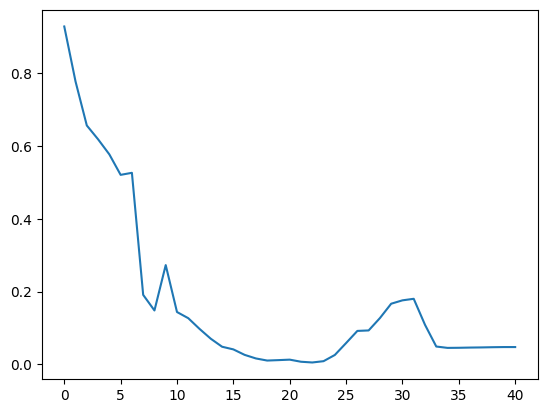

In [166]:
colonne = np.array(ks_result["moyenne_pvalue"])
plt.plot(colonne)
plt.show()

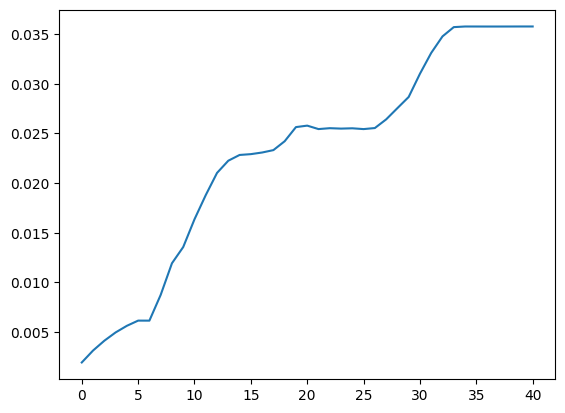

In [167]:
colonne = np.array(ks_result["moyenne_stat"])
plt.plot(colonne)
plt.show()

On aperçoit que les différences entre les distributions deviennent significatives (p value moyen inférieur à 0.05) à partir de la 15ème semaine. La différence moyenne augmente et la p value moyenne diminue après.

A la seixième semaine, la différence des variables "montant_total", "frais_livraison" et "nb_versement" augmente et la p value diminue (contrairement aux variables "satisfaction" et "retard_livraison"), ce qui doit entrainer les changement de cluster et donc la chute de l'ARI.

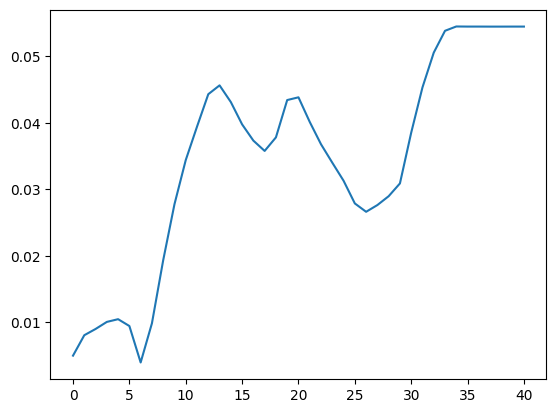

In [168]:
colonne = np.array(ks_result["retard_livraison_stat"])
plt.plot(colonne)
plt.show()

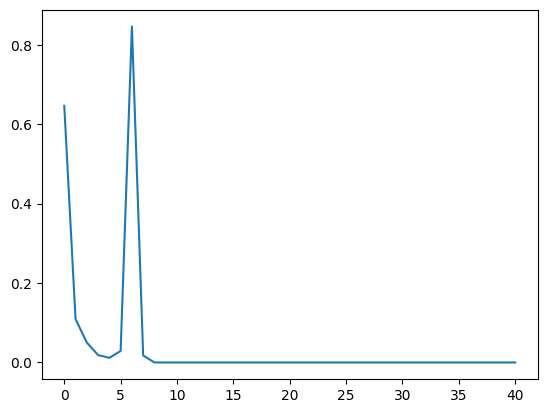

In [169]:
colonne = np.array(ks_result["retard_livraison_pvalue"])
plt.plot(colonne)
plt.show()

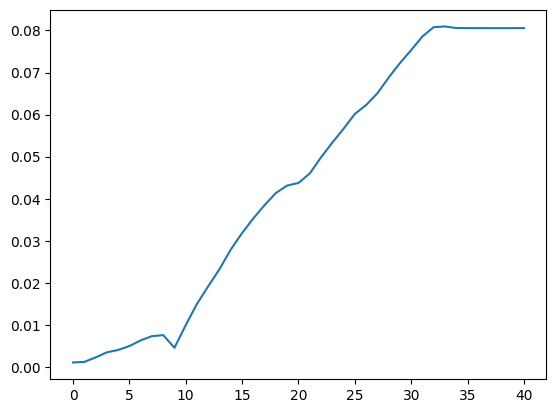

In [170]:
colonne = np.array(ks_result["frais_livraison_stat"])
plt.plot(colonne)
plt.show()

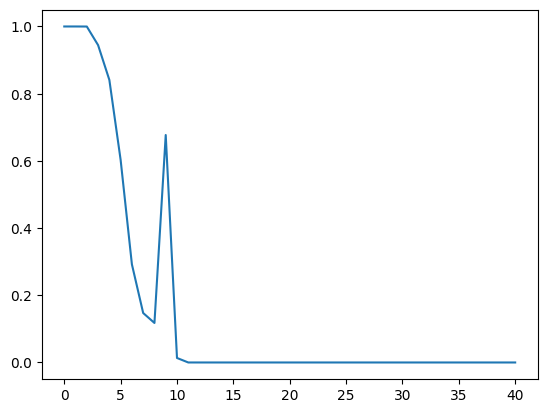

In [171]:
colonne = np.array(ks_result["frais_livraison_pvalue"])
plt.plot(colonne)
plt.show()

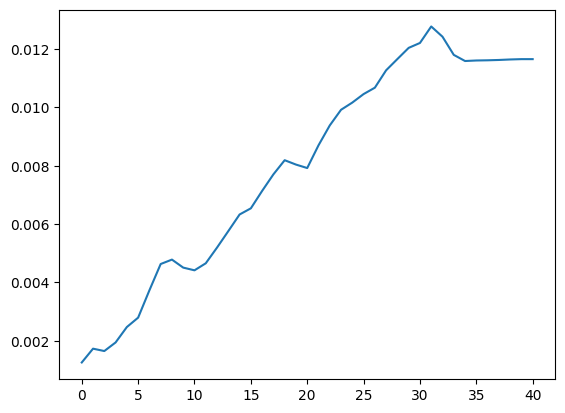

In [172]:
colonne = np.array(ks_result["montant_total_stat"])
plt.plot(colonne)
plt.show()

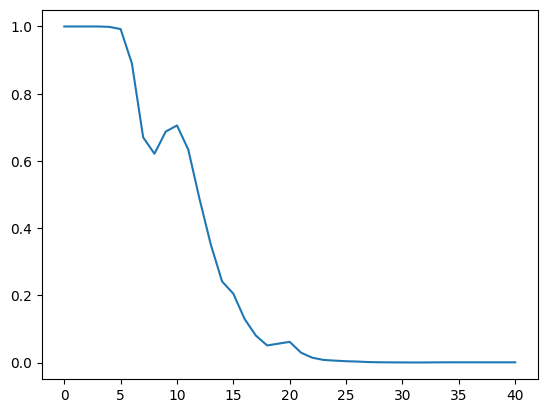

In [173]:
colonne = np.array(ks_result["montant_total_pvalue"])
plt.plot(colonne)
plt.show()

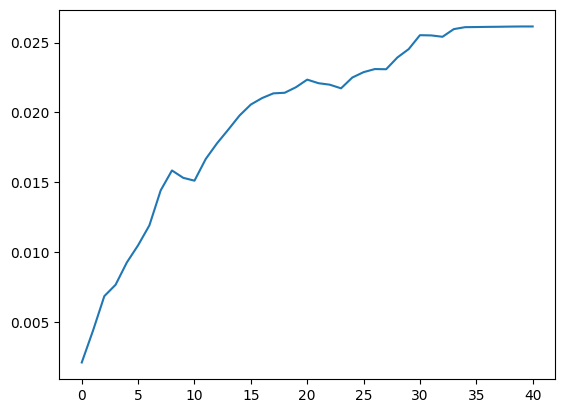

In [174]:
colonne = np.array(ks_result["nb_versement_stat"])
plt.plot(colonne)
plt.show()

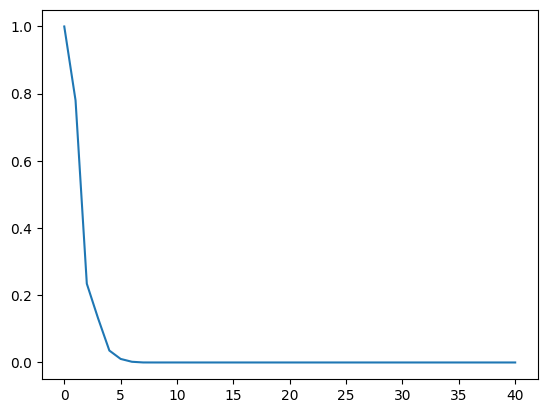

In [175]:
colonne = np.array(ks_result["nb_versement_pvalue"])
plt.plot(colonne)
plt.show()

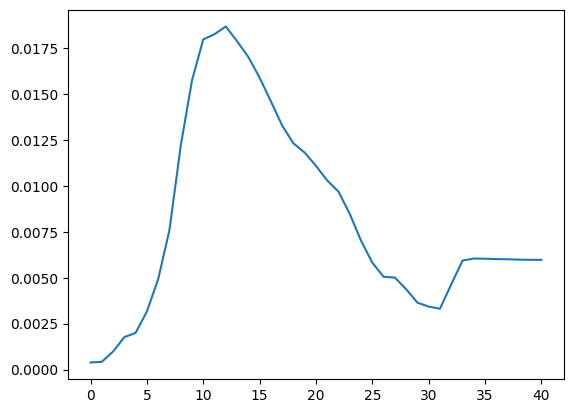

In [176]:
colonne = np.array(ks_result["satisfaction_stat"])
plt.plot(colonne)
plt.show()

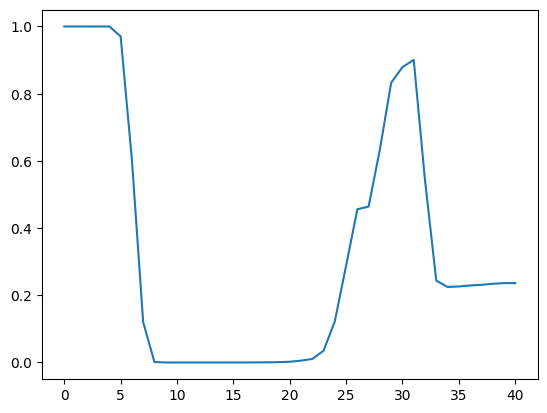

In [177]:
colonne = np.array(ks_result["satisfaction_pvalue"])
plt.plot(colonne)
plt.show()